### Requirements & Configurations

In [1]:
import sys  
sys.path.insert(0, '../')

In [2]:
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from catboost import CatBoostClassifier, Pool

from torch import nn
from IPython.display import clear_output
from tqdm import tqdm_notebook, tqdm
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from itertools import repeat
from data import *

import torch
import torch.nn.utils.prune as prune
import torch.nn.functional as F

import core.data.rich_utils as rich_utils

import wandb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os

%matplotlib inline

In [3]:
PARTICLE_TYPE = 'pion'

BATCH_SIZE = 4096
BATCH_SIZE_VAL = 1024
LATENT_DIMENSIONS = 128
NOISE_SIZE = 128
CRAMER_DIM = 512
NUM_LAYERS = 10

CRITIC_ITERATIONS_CONST = 10
TOTAL_ITERATIONS = int(6e4)
VALIDATION_INTERVAL = 10000

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Load dataset

In [4]:
from core.data.datasets import ParticleDataset
               

data_train, data_val, scaler = rich_utils.get_merged_typed_dataset(PARTICLE_TYPE, dtype=np.float32)
    
train_loader = torch.utils.data.DataLoader(ParticleDataset(data_train.values),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    pin_memory=True)

val_loader = torch.utils.data.DataLoader(ParticleDataset(data_val.values),
                                                  batch_size=BATCH_SIZE_VAL,
                                                  shuffle=False,
                                                  pin_memory=True)

scaler train sample size: 1500000
scaler n_quantiles: 100000, time = 1.6676747798919678


In [5]:
data_train.head(3)

,RichDLLe,RichDLLk,RichDLLmu,RichDLLp,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight
0,0.482666,0.053458,0.053947,-0.548041,0.269786,0.720969,0.676907,0.097714,0.883707
1,1.486169,-0.762816,1.142220,-0.881954,-0.295823,0.421586,-1.315679,0.559815,0.912539
2,-0.659258,0.147714,-0.582184,0.318019,0.308314,-0.715213,0.341952,1.057633,1.086270


### Load a model 

In [6]:
from torch.quantization import QuantStub, DeQuantStub

class Generator(nn.Module):
    def __init__(self, hidden_size=128, depth=5):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(hidden_size + data_train.shape[1] - 1 - rich_utils.y_count, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(0.1),
            *[nn.Sequential(
                nn.utils.spectral_norm(nn.Linear(hidden_size, hidden_size)),
                nn.BatchNorm1d(hidden_size),
                nn.LeakyReLU(0.1)) for _ in range(depth)
             ],
            nn.Linear(hidden_size, rich_utils.y_count)
        )
        
    def forward(self, x, noise=None):
        x = torch.cat([x, get_noise(x.shape[0])], dim=1)
        x = self.layers(x)
        return x
    
class Critic(nn.Module):
    def __init__(self, hidden_size=128, depth=5):
        super(Critic, self).__init__()
        self.layers = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(data_train.shape[1] - 1, hidden_size)),
            nn.LayerNorm(hidden_size),
            nn.LeakyReLU(0.1),
            *[nn.Sequential(
                nn.utils.spectral_norm(nn.Linear(hidden_size, hidden_size)),
                nn.LayerNorm(hidden_size),
                nn.LeakyReLU(0.1))
              for _ in range(depth)],
            nn.utils.spectral_norm(nn.Linear(hidden_size, 1)),
        )

    def forward(self, x):
        return self.layers(x)
    
        
def get_noise(batch_size, mean=0, std=1):
    return torch.zeros(batch_size, LATENT_DIMENSIONS).normal_(mean, std).to(device)

In [7]:
netG = Generator(depth=5).to(device)
netC = Critic(depth=5).to(device)

netC.load_state_dict(torch.load('../weights/C_teacher.pth', map_location={'cuda:3':device}))
netG.load_state_dict(torch.load('../weights/G_teacher.pth', map_location={'cuda:3':device}))

<All keys matched successfully>

In [8]:
def generate(generator, device='cuda', loader=val_loader, iterations=None):
    generator.eval()
    
    dlls = None
    generated = None
    weights = None
    features = None

    with torch.no_grad():
        current_iterations = 0
        for x, weight, real in loader:
            weight = weight.detach().cpu().numpy()
            dll = real.detach().cpu().numpy()
            x = x.to(device)
            gen = generator(x).detach().cpu().numpy()
            x = x.detach().cpu().numpy()

            if dlls is None:
                dlls = dll
            else:
                dlls = np.concatenate((dlls, dll))

            if weights is None:
                weights = weight
            else:
                weights = np.concatenate((weights, weight))

            if generated is None:
                generated = gen
            else:
                generated = np.concatenate((generated, gen))
            
            if features is None:
                features = x
            else:
                features = np.concatenate((features, x))
            
            current_iterations += 1
            if iterations is not None and current_iterations > iterations:
                break
    return dlls, generated, weights, features

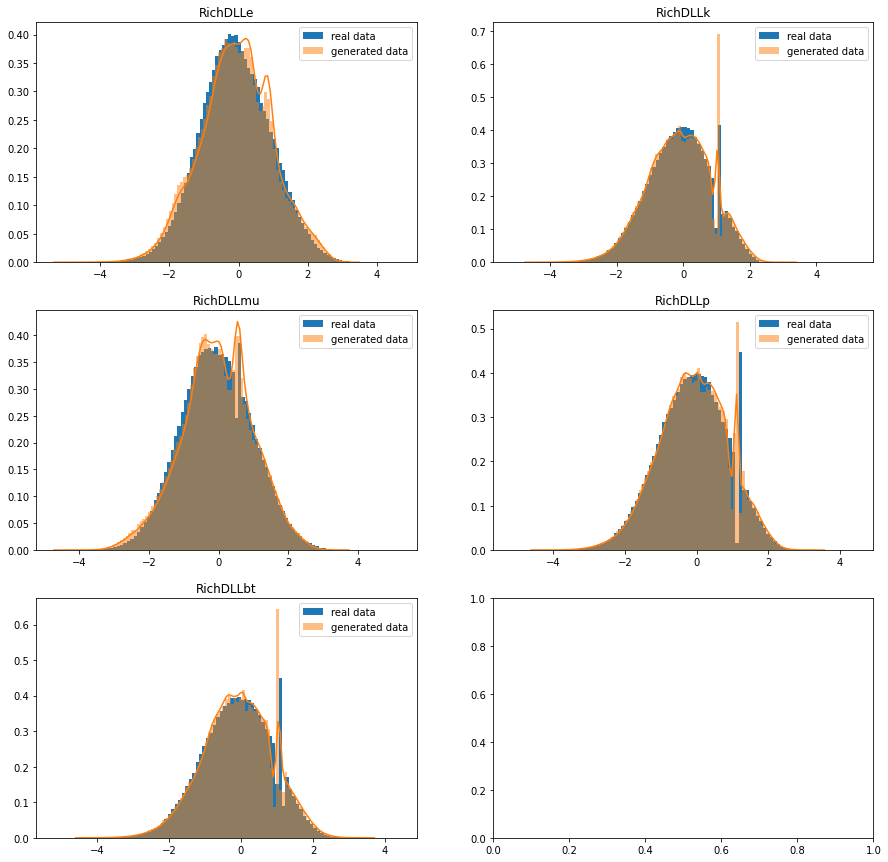

In [9]:
from core.metrics import hists

dlls, generated, weights, features = generate(netG)
hists.plot_1d_hist(dlls, generated, hist_kws={'weights': weights});

In [70]:
## calculate time in cpu
import time

device = 'cpu'
netG.cpu()

x = next(iter(val_loader))[0]
start_time = time.time()
with torch.no_grad():
    for _ in range(10000):
        netG(x)
    
print("--- %s seconds ---" % (time.time() - start_time))

device = 'cuda'
netG.cuda();

--- 90.01677322387695 seconds ---


In [101]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(netG)

Size (MB): 0.070002


In [102]:
from core.metrics import classification, kolmogorov_smirnov
from omegaconf.dictconfig import DictConfig

# stamp config
config = DictConfig({"metric": {"classification": {"iterations": 1000, "depth": None, "split_size": 0.99, "verbose_each_iter": 0}}, 
                     "utils": {"device": "cuda:0"}})

# kolmogorov-smirnov
ks_metrics = []
for i in range(5):
    ks_metrics.append(kolmogorov_smirnov.ks_2samp_w(dlls[:, i], generated[:, i], weights, weights))
print(f'ks: {ks_metrics}')

ks: [0.052419484, 0.03823632, 0.04091245, 0.04709387, 0.042080164]


### AUC

In [10]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

y = [1] * dlls.shape[0]
y.extend(list([0] * generated.shape[0]))
exp = np.exp(weights)
y_weights = np.concatenate((exp, exp), axis=0)
X = np.concatenate((dlls, generated))

y = np.expand_dims(y, axis=1)
y_weights = np.expand_dims(y_weights, axis=1)
y = np.concatenate((y, y_weights), axis=1)

# X = scaler.inverse_transform(np.hstack((X, np.zeros((X.shape[0], 3)))))[:,:5]

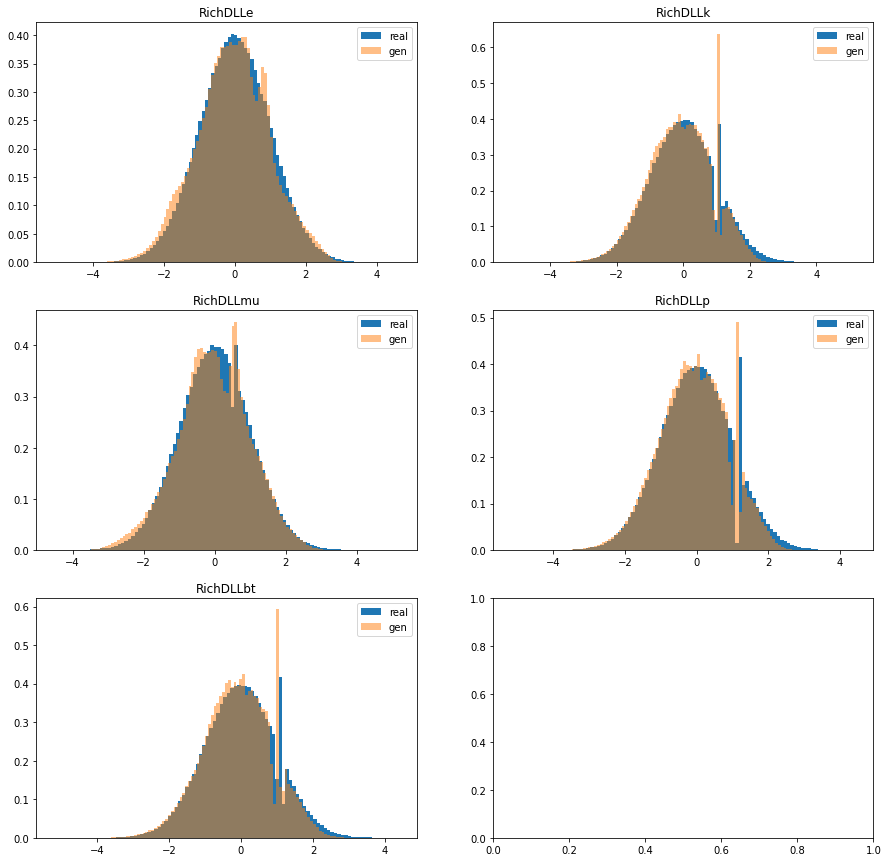

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
for particle_type, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
    sns.distplot(X[:len(X) // 2, particle_type], hist_kws={'alpha': 1}, kde=False, bins=100, ax=ax, label="real", norm_hist=True)
    sns.distplot(X[len(X) // 2:, particle_type], hist_kws={'alpha': 0.5}, kde=False, bins=100, ax=ax, label="gen", norm_hist=True)
    ax.legend()
    ax.set_title(rich_utils.dll_columns[particle_type])

plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [14]:
classifier = CatBoostClassifier(iterations=1000,
                custom_metric=['Logloss', 'AUC'],
                task_type="GPU",
                devices='0:1')

train_data = Pool(data=X_train,
                  label=y_train[:,0],
                  weight=y_train[:,1])

classifier.fit(train_data,
                verbose=False,
                plot=False);

In [15]:
from sklearn import metrics

predicted = classifier.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test[:,0], predicted, pos_label=1, sample_weight=y_test[:,1])
metrics.auc(fpr, tpr)

0.7322755210404869